# BorderLines Results Plots
This notebook visualizes results for KB CS, Consistency CS all, and Delta CS metrics across different models.

In [26]:
# Imports and setup
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

plt.rcParams.update({
    'font.size': 20,
    # 'font.family': 'serif',
    # 'font.serif': ['DejaVu Serif'],
    'axes.labelsize': 20,
    'axes.titlesize': 20,
    'xtick.labelsize': 20,
    'ytick.labelsize': 20,
    'legend.fontsize': 20
})

# Color palette for different model families
COLORS = {
    'random': 'grey',
    'bloom_560m': 'limegreen',
    'bloom_7b': 'green',
    'bloomz_560m': 'firebrick',
    'bloomz_7b': 'maroon',
    'gpt3_c': 'cornflowerblue',
    'gpt3_dv': 'royalblue',
    'gpt4': 'navy'
}

# Hatching patterns for GPT-4 variants
GPT4_HATCHES = {
    'input_demo': '///',
    'nationalist': '\\\\',
    'un': '---',
    'vanilla': '+++'
}

In [27]:
# Load and process data
df_full = pd.read_csv("../all_results/scores_for_all.csv")

# Extract random baseline values for plotting
random_baselines = {}
random_row = df_full[df_full['Model'] == 'random'].iloc[0]
for metric in ['KB CS', 'Consistency CS all', 'Delta CS']:
    random_baselines[metric] = random_row[metric]

# Create a filtered version without 'random' for plotting
df = df_full[df_full['Model'] != 'random'].copy()

# Create display labels
def create_display_label(row):
    model = row['Model']
    role = row['Role']
    if model == 'gpt4':
        return f"GPT-4 ({role})"
    else:
        # Clean up model names for display
        display_names = {
            'bloom_560m': 'BLOOM 560M',
            'bloom_7b': 'BLOOM 7B',
            'bloomz_560m': 'BLOOMZ 560M',
            'bloomz_7b': 'BLOOMZ 7B',
            'gpt3_c': 'GPT-3 Curie',
            'gpt3_dv': 'GPT-3 Davinci'
        }
        return display_names.get(model, model)

df['Display_Label'] = df.apply(create_display_label, axis=1)

# Separate GPT-4 variants from other models
gpt4_data = df[df['Model'] == 'gpt4'].copy()
other_data = df[df['Model'] != 'gpt4'].copy()

print(f"GPT-4 variants: {len(gpt4_data)}")
print(f"Other models: {len(other_data)}")
print(f"Total models: {len(df)}")
print(f"Random baselines: {random_baselines}")

GPT-4 variants: 4
Other models: 6
Total models: 10
Random baselines: {'KB CS': 43.5, 'Consistency CS all': 43.5, 'Delta CS': 0.0}


In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

# Function to add the 'random' model as a dotted line to a subplot
def plot_baseline(ax, metric, csv_path):
    """
    Adds the 'random' model as a dotted horizontal line to the given axis.
    Parameters:
        ax: matplotlib axis object
        metric: str, column name in the CSV to plot as baseline
        csv_path: str, path to the scores_for_all.csv file
    """
    df = pd.read_csv(csv_path)
    random_value = df[df['Model'] == 'random'][metric].values[0]
    ax.axhline(random_value, color='gray', linestyle=':', label='Random Baseline')

In [29]:
# Shared variables for plotting
metrics = ['KB CS', 'Consistency CS all', 'Delta CS']
y_labels = ['KB CS →', 'Cst CS →', 'Δ CS ←']

# Function to add the 'random' model as a dotted line to a subplot
def plot_baseline(ax, baseline_value, label=False):
    """
    Adds the 'random' model as a dotted horizontal line to the given axis.
    Parameters:
        ax: matplotlib axis object
        baseline_value: float, the baseline value to plot
        label: bool, whether to add a legend label
    """
    if label:
        ax.axhline(baseline_value, color='gray', linestyle=':', linewidth=2, zorder=0, label='Random baseline')
    else:
        ax.axhline(baseline_value, color='gray', linestyle=':', linewidth=2, zorder=0)

# Plotting function for non-GPT-4 models (with random baseline as dotted line, label only on last subplot)
def plot_other_models(df, figsize=(10, 10)):
    fig, axes = plt.subplots(3, 1, figsize=figsize)
    other_data = df[(df['Model'] != 'gpt4') & (df['Model'] != 'random')].copy()
    n_other = len(other_data)
    bar_width = 0.8
    positions = np.arange(n_other)
    for plot_idx, (metric, ylabel) in enumerate(zip(metrics, y_labels)):
        ax = axes[plot_idx]
        for i, (_, row) in enumerate(other_data.iterrows()):
            model = row['Model']
            value = row[metric]
            color = COLORS[model]
            bar = ax.bar(positions[i], value, bar_width, color=color, alpha=0.7)
            ax.text(positions[i], value + (2 if metric != 'Delta CS' or value >= 0 else -2),
                    f'{value:.1f}', ha='center', va='bottom' if metric != 'Delta CS' or value >= 0 else 'top',
                    color=color, fontsize=14, fontweight='bold')
        # Add random baseline using plot_baseline
        plot_baseline(ax, random_baselines[metric], label=(plot_idx == 2))
        ax.set_facecolor('#F5F5F5')
        ax.grid(True, axis='y', linestyle='--', alpha=0.3)
        ax.set_ylabel(ylabel)
        ax.set_xticks(positions)
        if plot_idx == 2:
            ax.set_xticklabels(list(other_data['Display_Label']), rotation=45, ha='right')
        else:
            ax.set_xticklabels([''] * len(positions))
        if metric == 'Delta CS':
            ax.set_ylim(0, 140)
        else:
            ax.set_ylim(40, 70)
    plt.tight_layout(rect=[0, 0, 1, 0.95])
    fig.text(0.02, 0.02, 'all 720 queries, varied models', fontsize=12, style='italic', alpha=0.7)
    plt.show()

In [30]:
# Plotting function for GPT-4 prompt comparison (label only on last subplot)
def plot_gpt4_prompts(df, figsize=(7, 10)):
    fig, axes = plt.subplots(3, 1, figsize=figsize)
    gpt4_data = df[df['Model'] == 'gpt4'].copy()
    if 'Mode_Label' not in gpt4_data.columns:
        def create_mode_label(row):
            role = row['Role']
            mode_names = {
                'input_demo': 'Demographics',
                'nationalist': 'Nationalist',
                'un': 'UN Peacekeeper',
                'vanilla': 'Vanilla'
            }
            return mode_names.get(role, role)
        gpt4_data['Mode_Label'] = gpt4_data.apply(create_mode_label, axis=1)
    n_gpt4 = len(gpt4_data)
    bar_width = 0.8
    positions = np.arange(n_gpt4)
    for plot_idx, (metric, ylabel) in enumerate(zip(metrics, y_labels)):
        ax = axes[plot_idx]
        for i, (_, row) in enumerate(gpt4_data.iterrows()):
            role = row['Role']
            value = row[metric]
            color = COLORS['gpt4']
            hatch = GPT4_HATCHES[role]
            bar = ax.bar(positions[i], value, bar_width, color=color, alpha=0.7, hatch=hatch, edgecolor='white', linewidth=0.5, label=row['Mode_Label'] if plot_idx == 2 else None)
            ax.text(positions[i], value + (2 if metric != 'Delta CS' or value >= 0 else -2), f'{value:.1f}', ha='center', va='bottom' if metric != 'Delta CS' or value >= 0 else 'top', color=color, fontsize=14, fontweight='bold')
        # Add random baseline using plot_baseline
        plot_baseline(ax, random_baselines[metric], label=(plot_idx == 2))
        ax.set_facecolor('#F5F5F5')
        ax.grid(True, axis='y', linestyle='--', alpha=0.3)
        ax.set_ylabel(ylabel)
        ax.set_xticks(positions)
        if plot_idx == 2:
            ax.set_xticklabels(list(gpt4_data['Mode_Label']), rotation=45, ha='right')
        else:
            ax.set_xticklabels([''] * len(positions))
        if metric == 'Delta CS':
            ax.set_ylim(0, 45)
        else:
            ax.set_ylim(40, 90)
    plt.tight_layout(rect=[0, 0, 1, 0.95])
    fig.text(0.02, 0.02, 'all 720 queries with varied prompts, GPT-4', fontsize=12, style='italic', alpha=0.7)
    plt.show()

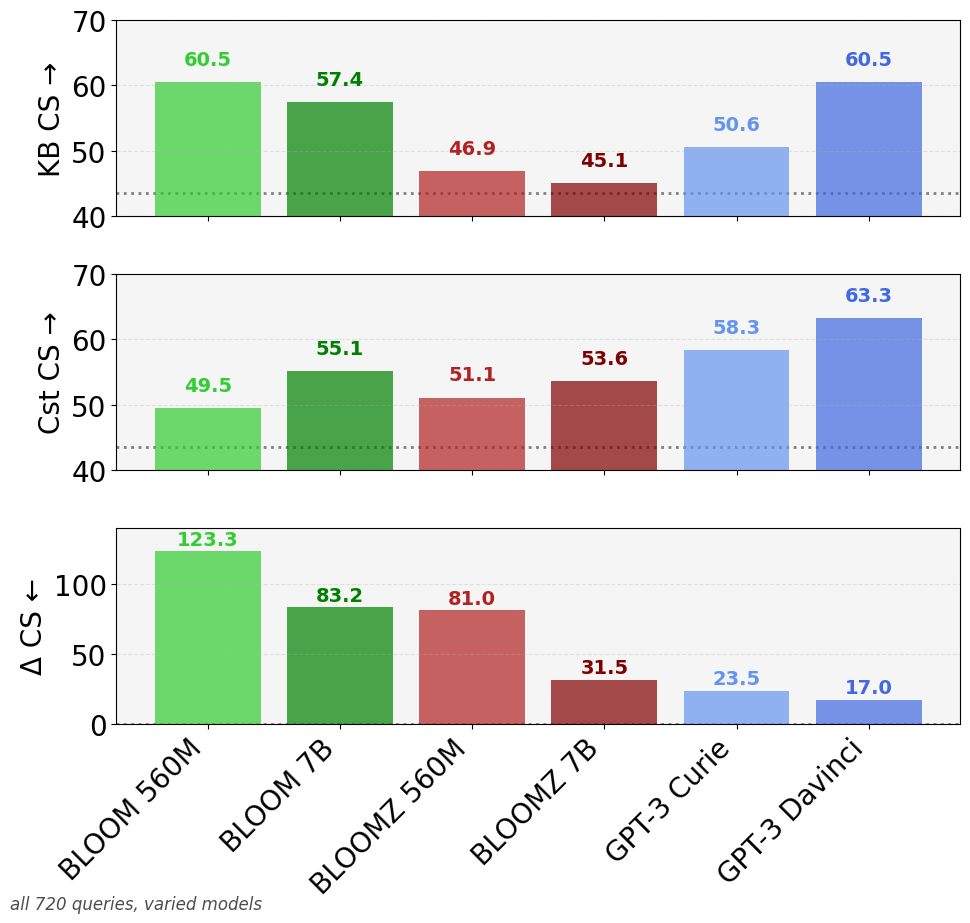

In [31]:
# Create the plots
plot_other_models(df)

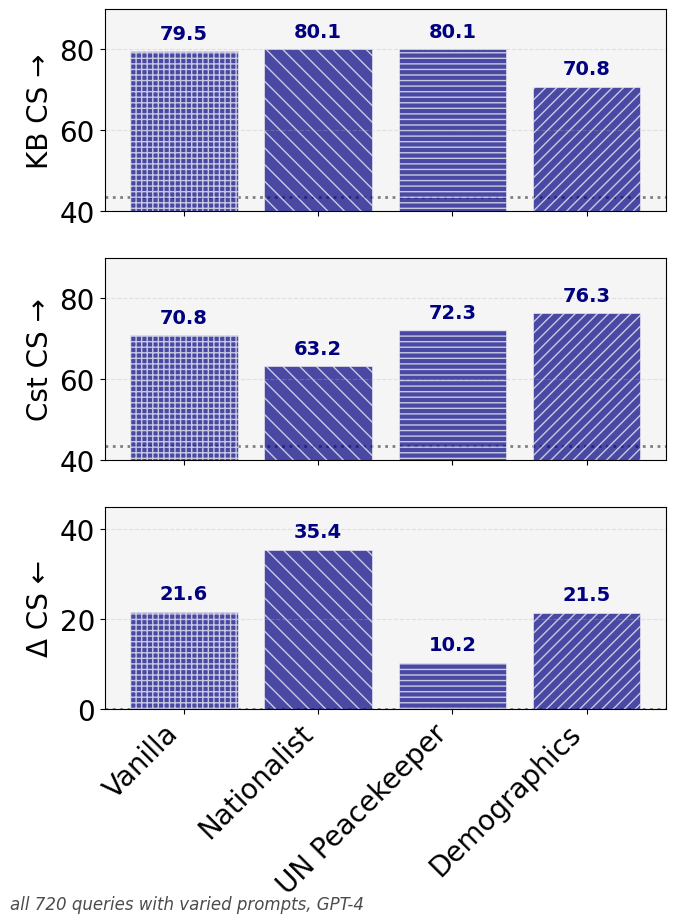

In [32]:
plot_gpt4_prompts(df)